In [95]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, f1_score
#import models

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.linear_model import Ridge ,Lasso
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import accuracy_score
import pickle
import xgboost as xgb

from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE , median_absolute_error as MAE

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold 

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
training = pd.read_csv('historical_data.csv')
training['created_at'] = pd.to_datetime(training['created_at'])
training['actual_delivery_time'] = pd.to_datetime(training['actual_delivery_time'])

training['subtotal'] = training['subtotal'].astype(float)

prediction_df = pd.read_csv('predict_data.csv')

In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   subtotal                                      197428 non-null  float64       
 5   total_onshift_dashers                         181166 non-null  float64       
 6   total_busy_dashers                            181166 non-null  float64       
 7   total_outstanding_orders                      181166 non-null  float64       
 8   estimated_store_to_consumer_driving_duration  196902 no

In [5]:
training['delivery_time'] = pd.to_datetime(training['actual_delivery_time'])-pd.to_datetime(training['created_at'])
training = training[~training.actual_delivery_time.isnull()].copy() # Remove all rows with missing data for time of delivery
training.market_id.fillna(training.market_id.mode()[0], inplace = True) # Imputing market_id with mode for Market_id
#training['delivery_mins'] = training['delivery_time'].dt.total_seconds().div(60).astype(int)
training['delivery_secs'] = training['delivery_time'].dt.total_seconds().astype(int)

In [6]:
training.head(2)

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time,delivery_secs
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441.0,33.0,14.0,21.0,861.0,0 days 01:02:59,3779
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900.0,1.0,2.0,2.0,690.0,0 days 01:07:04,4024


In [7]:
training.isnull().sum()

market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
subtotal                                            0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_store_to_consumer_driving_duration      526
delivery_time                                       0
delivery_secs                                       0
dtype: int64

In [8]:
""" CHeck delivery time distribution"""
"""
training.delivery_secs.value_counts(normalize=True)
#plot the bar graph of percentage delivery in seconds
training.delivery_secs.value_counts(normalize=True).plot.bar()
plt.show()

#plot the scatter plot of delivery time and market_id variable in data
plt.scatter(training.market_id,training.delivery_secs)
plt.show()
"""

'\ntraining.delivery_secs.value_counts(normalize=True)\n#plot the bar graph of percentage delivery in seconds\ntraining.delivery_secs.value_counts(normalize=True).plot.bar()\nplt.show()\n\n#plot the scatter plot of delivery time and market_id variable in data\nplt.scatter(training.market_id,training.delivery_secs)\nplt.show()\n'

In [9]:
def mat2df(mat, columns=None, index=None, dtype=None):
    """return a dataframe from a np matrix 
    Args:
        mat: np matrix 
    Return: 
    """
    return pd.DataFrame(mat, index=index, columns=columns, dtype=dtype)

def dump(df, save_path, **kwargs):
    """save a dataframe to a file
    :save_path: path to save
    :returns: None
    """
    ext = os.path.splitext(save_path)[1]
    assert ext in {".xls", ".xlsx", ".tsv", ".csv"}, "File Type not Supported!"

    verbose = kwargs.get('verbose', True)
    index = kwargs.get('index', False)
    encoding = kwargs.get('encoding', "utf-8")

    if ext in [".xls", ".xlsx"]: # excel
        df.to_excel(save_path, index=index)
    elif ext == ".csv":
        df.to_csv(save_path, index=index, encoding=encoding)
    elif ext == ".tsv":
        df.to_csv(save_path, index=index, sep="\t")
    if verbose: print("Data Dumped to {}".format(save_path))

In [10]:
training.head(10)

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time,delivery_secs
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441.0,33.0,14.0,21.0,861.0,0 days 01:02:59,3779
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900.0,1.0,2.0,2.0,690.0,0 days 01:07:04,4024
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900.0,1.0,0.0,0.0,690.0,0 days 00:29:41,1781
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900.0,1.0,1.0,2.0,289.0,0 days 00:51:15,3075
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900.0,6.0,6.0,9.0,650.0,0 days 00:39:50,2390
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,5000.0,2.0,2.0,2.0,338.0,0 days 00:38:20,2300
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,3900.0,10.0,9.0,9.0,638.0,0 days 00:26:24,1584
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,5477,4850.0,7.0,8.0,7.0,626.0,0 days 00:32:45,1965
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,4771.0,8.0,6.0,18.0,289.0,0 days 00:26:26,1586
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,5477,2100.0,2.0,2.0,2.0,715.0,0 days 00:53:12,3192


# EDA and Feature Engineering Started...

In [11]:
""" 
    Creating flags for early/late delivery :
    "Very Early" [-2]= arrived >10 mins early
    "Early"[-1] = arrived 2-10 mins early
    "Late"[1] = arrived 2-10 mins late
    "Very Late"[2] = arrived >10 mins late
    "On-time"[0] = On time with allowed buffer of +- 2 mins
"""
def late_logic(row):
    if (row['estimated_store_to_consumer_driving_duration'] - row['delivery_secs'] < 600) and (row['estimated_store_to_consumer_driving_duration'] - row['delivery_secs'] > 120):
        return -1
    elif (row['estimated_store_to_consumer_driving_duration'] - row['delivery_secs'] >= 600) :
        return -2
    elif (row['delivery_secs'] - row['estimated_store_to_consumer_driving_duration'] < 600) and (row['delivery_secs'] - row['estimated_store_to_consumer_driving_duration']  > 120):
        return  1
    elif (row['delivery_secs'] - row['estimated_store_to_consumer_driving_duration'] >= 600) :
        return 2
    elif (row['delivery_secs'] - row['estimated_store_to_consumer_driving_duration'] <= 120) or row['estimated_store_to_consumer_driving_duration'] - row['delivery_secs'] <= 120 :
        return 0
    else:
        return  0


In [12]:
training['late_flag'] = training.apply(late_logic, axis=1)


In [13]:
training['busy_or_not_busy'] = training['total_busy_dashers'] / training['total_onshift_dashers']
prediction_df['busy_or_not_busy'] = prediction_df['total_busy_dashers'] / prediction_df['total_onshift_dashers']
training.replace([np.inf, -np.inf], np.nan, inplace=True)
prediction_df.replace([np.inf, -np.inf], np.nan, inplace=True)
training.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time,delivery_secs,late_flag,busy_or_not_busy
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441.0,33.0,14.0,21.0,861.0,0 days 01:02:59,3779,2,0.424242
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900.0,1.0,2.0,2.0,690.0,0 days 01:07:04,4024,2,2.000000
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900.0,1.0,0.0,0.0,690.0,0 days 00:29:41,1781,2,0.000000
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900.0,1.0,1.0,2.0,289.0,0 days 00:51:15,3075,2,1.000000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900.0,6.0,6.0,9.0,650.0,0 days 00:39:50,2390,2,1.000000


In [77]:
prediction_df.head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,busy_or_not_busy
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096,1.000000
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895,0.250000
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868,0.777778
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076,1.000000
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200,1.000000


## Fill nan with default values

In [14]:
def df_mean(df, col):
    val = df[col]
    val = val[~np.isnan(val)]
    return np.mean(val)

def df_median(df, col):
    val = df[col]
    val = val[~np.isnan(val)]
    return np.median(val)

def df_mode(df, col):
    from collections import Counter
    c = Counter(df[col])
    return c.most_common()[0][0]

In [15]:
column_feature = [
 'subtotal', 
 'total_outstanding_orders',
 'estimated_store_to_consumer_driving_duration',
 'busy_or_not_busy']

In [16]:


default_fill_vals = {
     "subtotal": df_median(training, "subtotal"),
    "busy_or_not_busy": df_median(training, "busy_or_not_busy"),
    "total_outstanding_orders": df_median(training, "total_outstanding_orders"),
    "estimated_store_to_consumer_driving_duration": df_median(training, "estimated_store_to_consumer_driving_duration"),   
}

default_fill_vals


{'subtotal': 2200.0,
 'busy_or_not_busy': 0.9622641509433962,
 'total_outstanding_orders': 41.0,
 'estimated_store_to_consumer_driving_duration': 544.0}

In [17]:
def fill_df_with_default(df):
    df.fillna(default_fill_vals, inplace=True)
    

fill_df_with_default(training)
X = training[column_feature].to_numpy()
y = training["delivery_secs"]

    

In [18]:
training.isnull().sum()

market_id                                           0
created_at                                          0
actual_delivery_time                                0
store_id                                            0
subtotal                                            0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                            0
estimated_store_to_consumer_driving_duration        0
delivery_time                                       0
delivery_secs                                       0
late_flag                                           0
busy_or_not_busy                                    0
dtype: int64

# EDA and Feature Engineering Complete.  Model Training Start :

<h2> Linear Regression Implementation: <h2>

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=42)

# Fit regression model
clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mse = MSE(y_test, y_pred)
print("MSE: %.4f" % mse)


features_scored = []
for feature, coef in zip(column_feature, clf.coef_):
    features_scored.append((feature, coef))

features_scored.sort(key = lambda x: -abs(x[1]))
for feature, coef in features_scored:
    print("{:50}: {:.2f}".format(feature, coef))



MSE: 5135105.2277
busy_or_not_busy                                  : 177.24
total_outstanding_orders                          : 2.86
estimated_store_to_consumer_driving_duration      : 0.99
subtotal                                          : 0.10


In [98]:
import math
print(math.sqrt(MAE(y_test, y_pred)))

25.068029272542052


In [21]:

# prediction_df.drop(["market_id", "store_id", "created_at"], inplace=True, axis=1)
# print(prediction_df.shape)
fill_df_with_default(prediction_df)
X_test1 = prediction_df[column_feature].to_numpy()
lr_predicted = clf.predict(X_test1)

deliver_ids = prediction_df["delivery_id"]
rows = []
for id, seconds in zip(deliver_ids, lr_predicted):
    rows.append([id, int(seconds)])

output_df = mat2df(np.array(rows), ["delivery_id", "predicted_delivery_seconds"])

dump(output_df, save_path="predictions_liner_reg.csv")

Data Dumped to predictions_liner_reg.csv


<h2> Random Forest Implementation : <h2>

In [22]:
RFC=RandomForestRegressor(n_estimators=5,random_state=51,max_features = 0.30000000000000004)
RFC.fit(X_train, y_train)


RandomForestRegressor(max_features=0.30000000000000004, n_estimators=5,
                      random_state=51)

In [131]:
"""
Hyperparameter optimization for Random Forest
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators':np.arange(5,100,5),
                              'max_features':np.arange(0.1,1.0,0.05),
                            },cv=5, scoring="r2",verbose=1,n_jobs=-1, 
                             n_iter=50, random_state = 0
                           )
random_search.fit(X_train,y_train)

Result:
RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
                   random_state=0, scoring='r2', verbose=1)
"""

'\nHyperparameter optimization for Random Forest\nrandom_search = RandomizedSearchCV(RandomForestRegressor(random_state=0),\n                           {\n                              \'n_estimators\':np.arange(5,100,5),\n                              \'max_features\':np.arange(0.1,1.0,0.05),\n                            },cv=5, scoring="r2",verbose=1,n_jobs=-1, \n                             n_iter=50, random_state = 0\n                           )\nrandom_search.fit(X_train,y_train)\n\nResult:\nRandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),\n                   n_iter=50, n_jobs=-1,\n                   param_distributions={\'max_features\': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,\n       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),\n                                        \'n_estimators\': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,\n       90, 95])},\n                   random_state=0, scoring=

In [129]:
random_search = RandomizedSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators':np.arange(5,100,5),
                              'max_features':np.arange(0.1,1.0,0.05),
                            },cv=5, scoring="r2",verbose=1,n_jobs=-1, 
                             n_iter=50, random_state = 0
                           )
random_search.fit(X_train,y_train)

print('Best Parameters:', random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\nilan\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan -55.10745192          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan -55.10745192          nan          nan
          nan          nan          nan          nan          nan
  -0.07017561          nan          nan          nan          nan]
  category=UserWarning


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
                   random_state=0, scoring='r2', verbose=1)

In [23]:
rf_predicted = RFC.predict(X_test1)
rf_predicted

array([5382.2, 3446.2, 2654.4, ..., 2541. , 3594.6, 2661.2])

In [24]:
deliver_ids = prediction_df["delivery_id"]
rows = []
for id, seconds in zip(deliver_ids, rf_predicted):
    rows.append([id, float(seconds)])

output_df = mat2df(np.array(rows), ["delivery_id", "predicted_delivery_seconds"])

dump(output_df, save_path="predictions_random_forest.csv")

Data Dumped to predictions_random_forest.csv


In [100]:
y_pred = RFC.predict(X_test)

In [102]:

print('Mean Absolute Error (MAE):', MAE(y_test, y_pred))
print('Mean Squared Error (MSE):', MSE(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(MSE(y_test, y_pred)))
mape = np.mean(np.abs((y_test - y_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 631.0
Mean Squared Error (MSE): 87326046.801523
Root Mean Squared Error (RMSE): 9344.840651478387
Mean Absolute Percentage Error (MAPE): 32.54
Accuracy: 67.46


## XGBoost Implementation :

In [103]:

import xgboost as xgb

"""
Hyperparameter tuned model parameter :
RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000236C6374C48>,
            estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1,
                                    colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    gpu_id=-1, importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012,
                                    max_delta_step=0, max_depth=6,
                                    min_child_weight=1, missing=nan,
                                    monoton...
                                    objective='reg:linear',
                                    random_state=0, reg_alpha=0,
                                    reg_lambda=1, scale_pos_weight=1,
                                    subsample=1, tree_method='exact',
                                    validate_parameters=1,
                                    verbosity=None),
            n_iter=5, n_jobs=4,
            param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                    'gamma': [0.5, 1, 1.5, 2, 5],
                                    'max_depth': [3, 4, 5],
                                    'min_child_weight': [1, 5, 10],
                                    'subsample': [0.6, 0.8, 1.0]},
            random_state=1001, verbose=3)
"""
xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                                        colsample_bylevel=1,
                                        colsample_bynode=1,
                                        colsample_bytree=1, gamma=0,
                                        gpu_id=-1, importance_type='gain',
                                        interaction_constraints='',
                                        learning_rate=0.300000012,
                                        max_delta_step=0, max_depth=6,
                                        min_child_weight=1,objective='reg:linear',
                                        random_state=0, reg_alpha=0,
                                        reg_lambda=1,validate_parameters=1,
                                        verbosity=None)

xgbr.fit(X_train, y_train, verbose=False)

xg_pred = xgbr.predict(X_test)

rmse = np.sqrt(MSE(y_test, xg_pred))
print("RMSE : % f" %(rmse))
print('Mean Absolute Error (MAE):', MAE(y_test, xg_pred))
print('Mean Squared Error (MSE):', MSE(y_test, xg_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(MSE(y_test, xg_pred)))
mape = np.mean(np.abs((y_test - xg_pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))


[20:30:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  2369.799209
Mean Absolute Error (MAE): 578.6549072265625
Mean Squared Error (MSE): 5615948.291214066
Root Mean Squared Error (RMSE): 2369.7992090500125
Mean Absolute Percentage Error (MAPE): 28.03
Accuracy: 71.97


In [122]:
    """Hyper parameter optimization for XGBoost
    """
    
    params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
    
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgbr, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

C:\Users\nilan\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[23:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000236C6374C48>,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monoton...
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                 

In [26]:
"""
Predicting delivery seconds
"""
xg_predicted = xgbr.predict(X_test1)
xg_predicted

array([3467.1626, 2858.6775, 2569.6448, ..., 2885.685 , 2929.7886,
       2182.7688], dtype=float32)

In [27]:
deliver_ids = prediction_df["delivery_id"]
rows = []
for id, seconds in zip(deliver_ids, xg_predicted):
    rows.append([id, float(seconds)])

output_df = mat2df(np.array(rows), ["delivery_id", "predicted_delivery_seconds"])

dump(output_df, save_path="predictions_xgb.csv")

Data Dumped to predictions_xgb.csv


In [28]:
prediction_df.columns

Index(['market_id', 'created_at', 'store_id', 'subtotal',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'delivery_id',
       'busy_or_not_busy'],
      dtype='object')

In [43]:
    """
    Creating a final dataset to perform analsis of the distrbution of delivery lateness across stores and market 
    """
    
new_df = prediction_df[['store_id', 'market_id','delivery_id','subtotal','busy_or_not_busy', 'estimated_store_to_consumer_driving_duration']]
new_df['LR_prediction'] = lr_predicted
new_df['RF_prediction'] = rf_predicted
new_df['XGboost_prediction'] = xg_predicted
new_df['delivery_diff_w_LR_pred'] = new_df['LR_prediction'] - new_df['estimated_store_to_consumer_driving_duration']
new_df['delivery_diff_w_RF_pred'] = new_df['RF_prediction'] - new_df['estimated_store_to_consumer_driving_duration']
new_df['delivery_diff_w_XGB_pred'] = new_df['XGboost_prediction'] - new_df['estimated_store_to_consumer_driving_duration']
new_df['avg_variance'] = np.abs(new_df.loc[: , "delivery_diff_w_LR_pred":"delivery_diff_w_XGB_pred"].mean(axis=1))
dump(new_df, save_path="predictions_combined.csv")

C:\Users\nilan\anaconda3\envs\myenv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Data Dumped to predictions_combined.csv


In [44]:
new_df.tail(2)

,store_id,market_id,delivery_id,subtotal,busy_or_not_busy,estimated_store_to_consumer_driving_duration,LR_prediction,RF_prediction,XGboost_prediction,delivery_diff_w_LR_pred,delivery_diff_w_RF_pred,delivery_diff_w_XGB_pred,avg_variance
54776,2956,1.0,178028,1438,1.000000,593.0,2733.606530,3594.6,2929.788574,2140.606530,3001.6,2336.788574,2492.998368
54777,3630,1.0,132824,1433,0.763889,454.0,2733.764978,2661.2,2182.768799,2279.764978,2207.2,1728.768799,2071.911259


In [38]:
new_df['store_id'].nunique()

5676

<AxesSubplot:xlabel='market_id'>

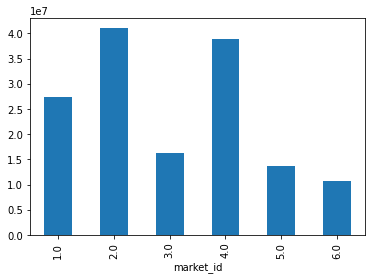

In [70]:
new_df.groupby('market_id')['subtotal'].sum().plot(kind='bar')

In [82]:
new_gp = new_df.groupby('market_id')

for key, item in new_gp:
    gp = pd.DataFrame(xxxx.get_group(key))
    #print(gp.head(2))
      

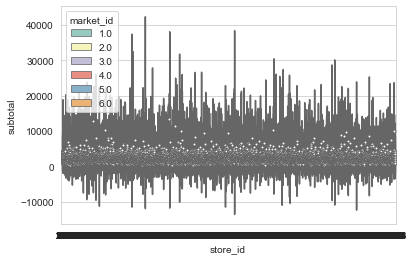

In [94]:

sns.set_style("whitegrid")
plot = sns.violinplot(y ='subtotal', x ='store_id', data = new_df, hue="market_id", palette="Set3", height=10, aspect=20.7/10)

fig = plot.get_figure()
fig.savefig("violinplot_store_analysis_by_market.png")

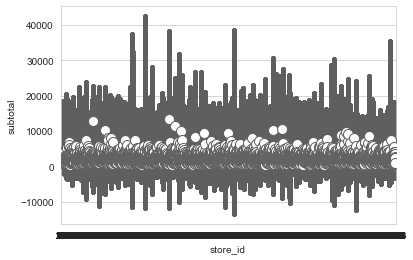

In [92]:
sns.set_style("whitegrid")
plot = sns.violinplot(y ='subtotal', x ='store_id', data = new_df,  palette="Set3", linewidth = 5, height=10, aspect=20.7/10)

fig = plot.get_figure()
fig.savefig("store_analysis_violinplot.png")

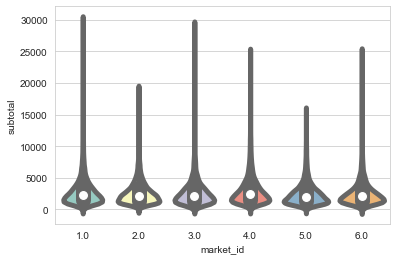

In [104]:
sns.set_style("whitegrid")
plot = sns.violinplot(y ='subtotal', x ='market_id', data = new_df,  palette="Set3", linewidth = 5, height=10, aspect=20.7/10)

fig = plot.get_figure()
fig.savefig("market_analysis_violinplot.png")